# CAM304

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Rede de Convolução / Visão Computacional

### Prof. Eduardo Luz / Eduluz@ufop.edu.br

Objetivos:

- Aplicação de filtros em imagens por meio de convolução
- Entendimento do uso de stride, padding e pooling
- Modelagem de uma rede de convolução para o problema de rec. de face da AT&T
- Uso do VGG pr-e-treinado como um extrator de caracterĩsticas
- Uso do MobileNet pré-treinado para classificação de faces : transferência de aprenzagem
- Notebook baseado em tensorflow e Keras.

Data da entrega : a ser definido

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Crie um repositório no github para o grupo e me convide como colaborador (eduluzufop). Por fim, me envie o link do github.


-----------------------------------------------------------------------------

# Os integrantes do grupo são: Airque Rubim de Assis, Bruno Moreira da Silva, Felipe Augusto Tavares e Felippe Fernando Barbosa.

# 1. Aplicando filtros e entendendo padding, stride e pooling (20pt)

## 1.1. Importando pacotes e montando o drive

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from tensorflow.keras import datasets, layers, models
import os
import skimage
from skimage import io
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize

## 1.2. Carregando uma imagem

Carregue um imagem do disco, para usar como exemplo.

sample image shape:  (512, 512, 3)


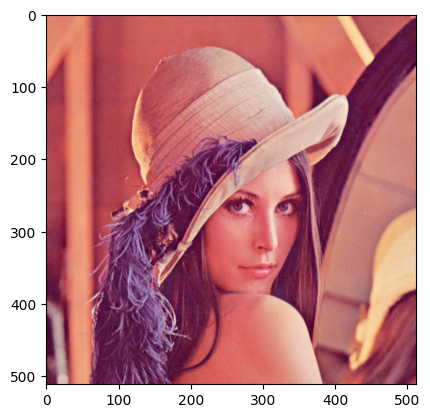

In [ ]:
# carrega imagem de exemplo
sample_image = imread("/content/drive/My Drive/Lenna.png")
sample_image= sample_image.astype(float)

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

In [ ]:
# veja o shape da imagem
sample_image.shape

(512, 512, 3)

## 1.3. Criando e aplicando um filtro com convolução

Utilize o tf/Keras para aplicar o filtro. Observe que nesta etapa não há necessidade de treinamento algum. O código abaixo cria 3 filtros de tamanho 5x5, e adiciona padding de forma a manter a imagem de saída (filtrada) do mesmo tamanho da imagem de entrada (padding ="same").

In [ ]:
#cria um objeto sequencial com apenas uma camada de convolução do tipo tf.keras.layers.Conv2D
conv = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3))
])
conv.output_shape

(None, None, None, 3)

In [ ]:
conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 3)     228       
                                                                 
Total params: 228 (912.00 Byte)
Trainable params: 228 (912.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# com TF/kertas, as convoluções esperam vetores no formato : (batch_size, dim1, dim2, dim3). Ou seja, a primeria posição é o tamanho do lote.
# Uma imagem isolada é considerada um lote de tamanho 1, portanto, deve-se expandir mais uma dimenão do tensor.
img_in = np.expand_dims(sample_image, 0)
img_in.shape

(1, 512, 512, 3)

Agora, pode-se aplicar a convolução. Aplique a convolução na imagem de exemplo (expandida) e verifique o tamanho da imagem resultante (img_out). Use a função predict do objeto conv para aplicar a convolução.

In [ ]:
img_out = conv(img_in)
img_out.shape

TensorShape([1, 512, 512, 3])

Plote as imagens lado a lado e observe o resultado. O parâmetro "same" no padding aplica um padding automático no sentido de garantir que a saída tenha o mesmo tamanho da entrada.
Lembre-se que o padding adiciona zeros nas bordas da imagem, antes da aplicação da convolução.

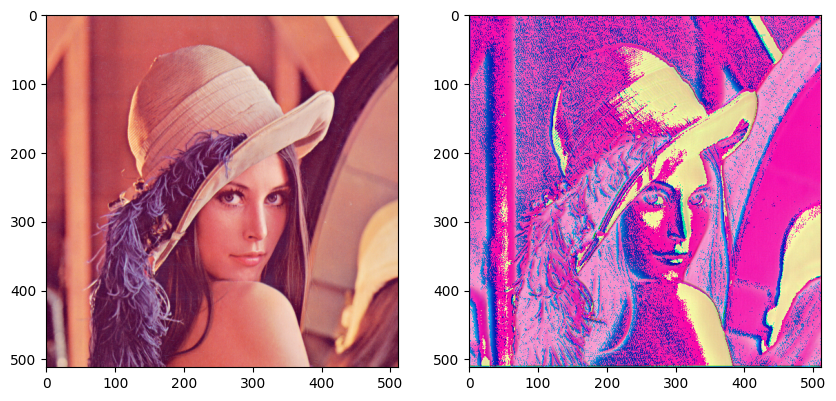

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
ax1.imshow(img_out[0].numpy().astype('uint8'));

Repita o mesmo procedimento, trocando padding de 'same' para 'valid', usando apenas um filtro.

In [ ]:
conv2 = Sequential([
    Conv2D(filters=1, kernel_size=(5, 5), padding="valid",
           input_shape=(None, None, 3))
])
conv2.output_shape

(None, None, None, 1)

In [ ]:
conv2.summary() # 1 filtro 5x5x3 ... a profundidade do filtro é de acordo com a entrada. 5x5x3 = 75; Não esqueça do bias!


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, None, None, 1)     76        
                                                                 
Total params: 76 (304.00 Byte)
Trainable params: 76 (304.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
img_out = conv2(img_in)
img_out[0].shape

TensorShape([508, 508, 1])

Plote as duas imagens lado a lado

In [ ]:
#  Como tivemos que expandir a primeira dimensao para aplicar a convolução, podemos remover a dimensão unitária para plotar a imagem, usando a função squeeze()
i = img_out[0].numpy().squeeze()
i.shape

(508, 508)

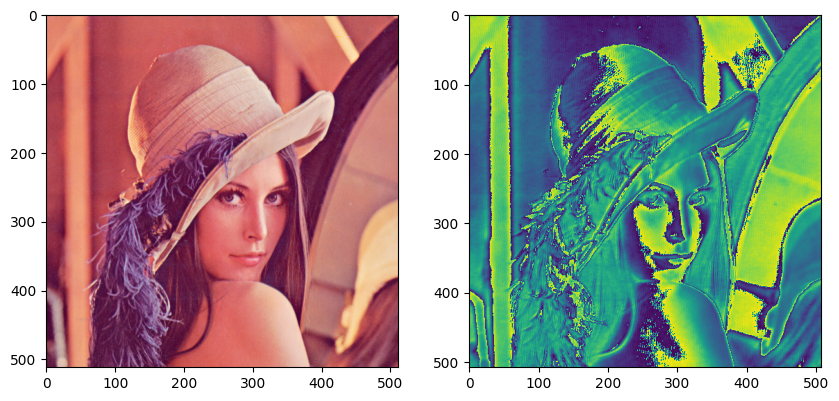

In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(sample_image.astype('uint8'))
i = img_out[0].numpy().squeeze()
ax1.imshow(i.astype('uint8'));

## 1.4. Inicializando os filtros na mão


A função abaixo inicializa um array de dimensões 5,5,3,3 com todas as posições zero, exceto as posições 5,5,0,0 , 5,5,1,1 e 5,5,2,2 que recebem o valor 1/25.

In [ ]:
def my_filter(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=np.float32)
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

In [ ]:
# transposição apenas para ajudar na visualização
np.transpose(my_filter(), (2, 3, 0, 1))

array([[[[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]]],


       [[[0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  ]],

        [[0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
         [0.04, 0.04, 0.04, 0.04, 0.04],
      

In [ ]:
# a função definida acima é usada para carregar valores nos filtros.
# use a função my_filter() para pre-inicializar os filtros do objeto conv3.
#
conv3 = Sequential([
     Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_filter)
])
conv3.output_shape

(None, None, None, 3)

## 1.5. Plote e observe o que aconte com a imagem (1pt)



Foi observada uma redução da nitidez na imagem.

1/1 [==============================] - 0s 217ms/step


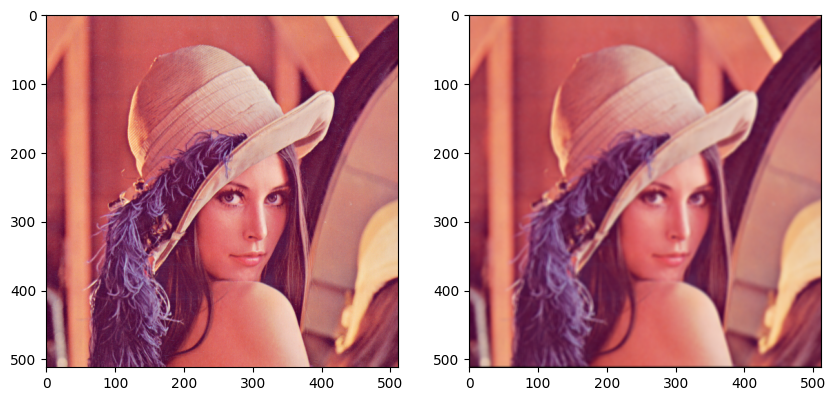

In [ ]:
# observe o que aconte com a imagem
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv3.predict(img_in)[0].astype('uint8'));

In [ ]:
img_in[0].shape

(512, 512, 3)

In [ ]:
conv3.predict(img_in)[0].shape

1/1 [==============================] - 0s 29ms/step


(512, 512, 3)

### Responda

**ToDo** : Foi realizado a convolução da imagem, de modo que o Filtro foi iniciado com o valores já predefinidos no caso um array de dimensões 5,5,3,3 com todas as posições zero, exceto as posições 5,5,0,0 , 5,5,1,1 e 5,5,2,2 que recebem o valor 1/25, ao aplicar o filtro na imagem, podemos observar um desfoque na imagem ou sejá podemos perceber que houve uma dimunição da nitidez da imagem. Lembrando que a camada Conv2D é usada para realizar convoluções 2D na entrada. Essa operação envolve mover um pequeno filtro (kernel) pela imagem de entrada, multiplicando os valores dos pixels na região de sobreposição e somando os resultados para produzir um único valor na imagem de saída, realizando esta operação no nosso caso resultou em um redução da nitidez da imagem.


## 1.6. Filtros de borda (5pt)

**ToDo** : Crie uma nova função para gerar um filtro de borda nos 3 canais da imagem de entrada. O filtro deve ser 3x3 e ter o formato [[0 0.2 0] [0 -0.2 0] [0 0 0]] (2pt)

In [ ]:
def my_filter(shape=(1, 3, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype=np.float32)
    array[:, 1 , 0, 0] = 0.2
    array[:, 1 , 0, 1] = -0.2
    array[:, 1 , 0, 2] = 0
    array[:, 1 , 1, 0] = 0.2
    array[:, 1 , 1, 1] = -0.2
    array[:, 1 , 1, 2] = 0
    array[:, 1 , 2, 0] = 0.2
    array[:, 1 , 2, 1] = -0.2
    array[:, 1 , 2, 2] = 0
    return array

In [ ]:
# transposição apenas para ajudar na visualização
np.transpose(my_filter(), (2, 3, 0, 1))

array([[[[ 0. ,  0.2,  0. ]],

        [[ 0. , -0.2,  0. ]],

        [[ 0. ,  0. ,  0. ]]],


       [[[ 0. ,  0.2,  0. ]],

        [[ 0. , -0.2,  0. ]],

        [[ 0. ,  0. ,  0. ]]],


       [[[ 0. ,  0.2,  0. ]],

        [[ 0. , -0.2,  0. ]],

        [[ 0. ,  0. ,  0. ]]]], dtype=float32)

Inicialize o objeto conv4 com seu novo filtro e aplique na imagem de entrada

In [ ]:
conv4 = Sequential([
    Conv2D(filters=3, kernel_size=(5, 5), padding="same",
           input_shape=(None, None, 3), kernel_initializer=my_filter)
])
conv4.output_shape

(None, None, None, 3)

1/1 [==============================] - 0s 151ms/step


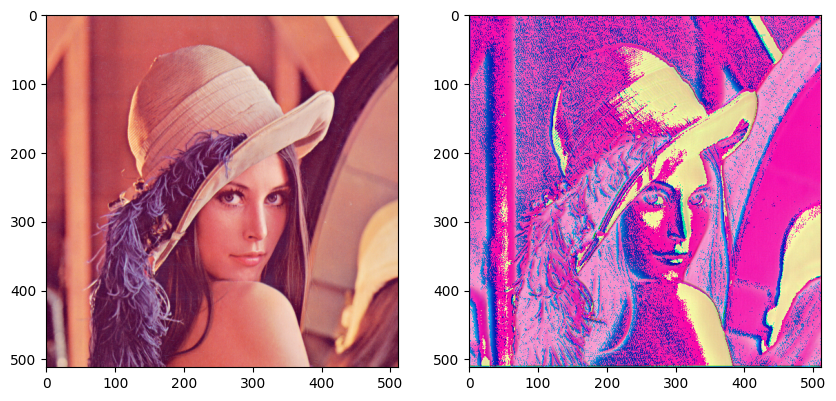

In [ ]:
# Plote as duas iamgens lado a lado (filtrada e não filtrada)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(conv.predict(img_in)[0].astype('uint8'));

## 1.7. Pooling (14pt)



Aplique um max-pooling na imagem, com uma janela de 2x2. Faça com stride de 2 e observe o resultado na imagem de saída.

In [ ]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)

max_pool = Sequential(
    MaxPool2D(pool_size=(2, 2), strides=2, input_shape=(None, None, 3))
)
max_pool.output_shape

(None, None, None, 3)

In [ ]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool.predict(img_in) # aplica o pooling

1/1 [==============================] - 0s 116ms/step


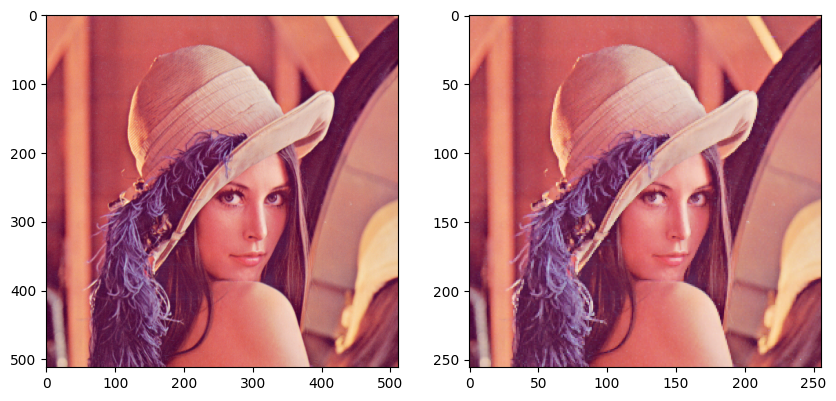

In [ ]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 4, repita o processo e observe o resultado na imagem de saída.




In [ ]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool2 = Sequential(
    MaxPool2D(pool_size=(2, 2), strides=4, input_shape=(None, None, 3))
)
max_pool2.output_shape

(None, None, None, 3)

In [ ]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool2.predict(img_in) # aplica o pooling

1/1 [==============================] - 0s 252ms/step


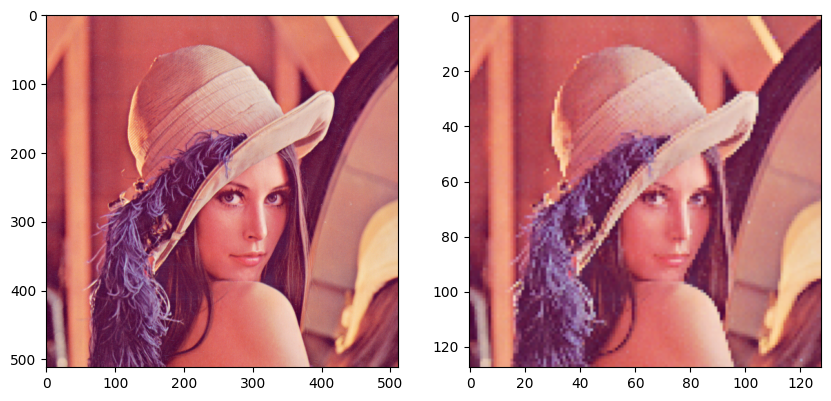

In [ ]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

Aumente o stride para 8, repita o processo e observe o resultado na imagem de saída. A

In [ ]:
# cria um objeto Sequencial de nome max_pool, apenas contendo uma camada de tf.keras.layer.MaxPool2D.
# lembre-se de colucar o parametro input-shape como input_shape=(None, None, 3)
# Coloque o parametro stride para 4

max_pool3 = Sequential(
    MaxPool2D(pool_size=(2, 2), strides=8, input_shape=(None, None, 3))
)
max_pool3.output_shape

(None, None, None, 3)

In [ ]:
img_in = np.expand_dims(sample_image, 0) # expande a imagem
img_out = max_pool3.predict(img_in) # aplica o pooling

1/1 [==============================] - 0s 100ms/step


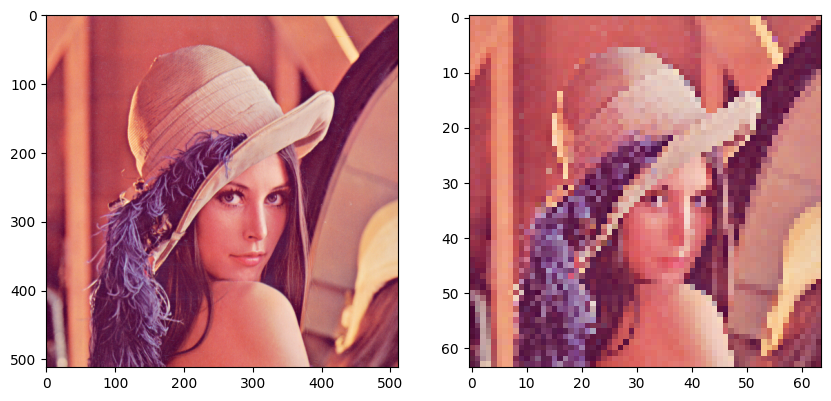

In [ ]:
# plota as imagens lado a lado
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.imshow(img_in[0].astype('uint8'))
ax1.imshow(img_out[0].astype('uint8'));

### Responda

**ToDo** - Descreva o que aconteceu com o aumento do stride.

Com o aumento do stride, foi possivel observar uma diminuição nos pixeis da imagem. Analisando visualmente os plots, podemos concluir que houve uma diminuição na qualidade e na dimensão do retrato.

# 2. Reconhecimento de Faces usando uma rede de convolução (20pt)




O objetivo desta etapa é classificar faces na base ORL (AT&T) Database (40 individuos x 10 imagens, de resolução 92x112 pixels e 256 níveis de cinza).

Baixe as imagens no site http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html ou da pasta dataset do Drive.

## 2.1. Preparando os dados (5pt)

In [ ]:
# carregue as imagens

# inicializa matrizes X e y
X = np.empty([400, 112, 92]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/My Drive/AttFaces"
i=0
class_id = 0
for f in os.listdir(imgs_path):
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                X[i, :, :] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id
                i = i + 1


print("dimensões da matriz X = " , X.shape)

dimensões da matriz X =  (400, 112, 92)


In [ ]:
# Divida os dados em treino e teste (70%-30%) com a função train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X_train.shape

(280, 112, 92)

In [ ]:
X_test.shape

(120, 112, 92)

Dos 400 dados, 280 foram alocados para treinamento e 120 para teste, deste modo realmente tendo 70% para treinamento e 30% para teste.

## 2.2. Implementando a rede (15pt)

Implemente uma rede de convolução simples, contendo 3 camadas de convolução seguidas de camadas max-pooling. Duas camadas densas (totalemtne conectadas) no final e por fim uma camada com ativação softmax para a classificação. Escolha filtros de tamanhos variados : (3,3) ou (5,5). Para cada camada, crie de 32 a 96 filtros.
Na camada densa, use de 64 a 200 neurônios.

Use o comando model.summary() para conferir a arquitetura.

In [ ]:
# Implementa uma rede de convolução simples, chamada model

input_size = (X.shape[1], X.shape[2],1)
n_classes = 40

model = models.Sequential()

# Adicionando o Input

model.add(layers.InputLayer(input_shape=input_size))

# Implementando as camadas

model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", input_shape=(None, None, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, input_shape=(None, None, 3)))


model.add(layers.Conv2D(filters=96, kernel_size=(3, 3), padding="same", input_shape=(None, None, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, input_shape=(None, None, 3)))


model.add(layers.Conv2D(filters=88, kernel_size=(3, 3), padding="same", input_shape=(None, None, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, input_shape=(None, None, 3)))

# Adicionando a camada flatten

model.add(layers.Flatten())

# Adicionanado a camada densa

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(86, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 112, 92, 64)       1664      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 46, 96)        55392     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 23, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 23, 88)        76120     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 11, 88)       

Seu modelo deve ter uma saída aproximadamente como abaixo:



```
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_60 (Conv2D)           (None, 110, 90, 32)       320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 55, 45, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 53, 43, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 26, 21, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 19, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 29184)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                1867840   
_________________________________________________________________
dense_10 (Dense)             (None, 40)                2600      
=================================================================
Total params: 1,926,184
Trainable params: 1,926,184
Non-trainable params: 0
_________________________________________________________________
```



In [ ]:
# repare bem o shape de x_train. A priumeira dimensão é o tamanho do lote, a segunda e terceira são referentes ao taamnho das imagens.
# repare que as imagens desta base tem apenas uma banda (escala de cinza)
X_train.shape

(280, 112, 92)

In [ ]:
# Como o tensor acima não contempla o tamanho de canais (no caso , igual a 1), deve-se expandir a última dimensão para deixar a entrada compatĩvel com o que é esperado pelo modelo do tf.keras
X_train_new = np.expand_dims(X_train, -1)
X_test_new = np.expand_dims(X_test, -1)

X_train_new.shape

(280, 112, 92, 1)

In [ ]:
# o vetor de rótulos não precisa ter duas diemnões.
y_train_new = y_train.squeeze()
y_test_new = y_test.squeeze()

# e deve ficar na faixa entre 0 e 39
y_train_new = y_train_new - 1;
y_test_new = y_test_new - 1;

Compile o modelo usando o método de otimização=adam e função de custo (loss) = sparse_categorical_crossentropy.

In [ ]:
model.compile(optimizer ="adam", loss = "sparse_categorical_crossentropy", metrics=['accuracy'])

Treine o modelo por 30 épocas com batch_size = 100.

In [ ]:
history = model.fit(X_train_new, y_train_new, epochs=30, batch_size = 100, validation_data=(X_test_new, y_test_new))

Epoch 1/30
3/3 [==============================] - 9s 1s/step - loss: 134.8998 - accuracy: 0.0286 - val_loss: 119.3608 - val_accuracy: 0.0167
Epoch 2/30
3/3 [==============================] - 0s 93ms/step - loss: 82.4173 - accuracy: 0.0250 - val_loss: 107.3796 - val_accuracy: 0.0333
Epoch 3/30
3/3 [==============================] - 0s 90ms/step - loss: 66.0350 - accuracy: 0.0250 - val_loss: 47.6545 - val_accuracy: 0.0250
Epoch 4/30
3/3 [==============================] - 0s 88ms/step - loss: 33.9229 - accuracy: 0.0143 - val_loss: 21.3217 - val_accuracy: 0.0167
Epoch 5/30
3/3 [==============================] - 0s 90ms/step - loss: 39.8611 - accuracy: 0.0107 - val_loss: 22.2869 - val_accuracy: 0.0417
Epoch 6/30
3/3 [==============================] - 0s 75ms/step - loss: 28.4006 - accuracy: 0.0464 - val_loss: 37.3437 - val_accuracy: 0.0083
Epoch 7/30
3/3 [==============================] - 0s 89ms/step - loss: 35.2925 - accuracy: 0.0357 - val_loss: 27.5605 - val_accuracy: 0.0417
Epoch 8/30
3

O retorno da função fit() é um objeto para armazenar o histõrico do treino.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plote a acurácia e o custo (loss) do treino e da validação.

4/4 - 1s - loss: 2.2190 - accuracy: 0.4500 - 555ms/epoch - 139ms/step


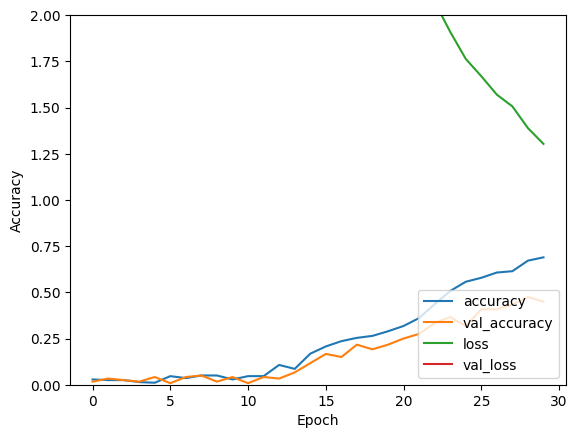

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 2])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 2])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_new,  y_test_new, verbose=2)

In [ ]:
print(test_acc)

0.44999998807907104


# 3. Usando um modelo Pré-treinado : VGG (10pt)

Carregando os dados da base AT&T para o VGG. Como a base está em escala de cinza e a entrada do modelo VGG espera uma imagem colorida (RGB), vamos repetir a mesma imagem em cada uma das bandas.

## 3.1. Preparando os dados (2pt)


In [ ]:
# inicializa matrizes X e y
X = np.empty([400, 112, 92, 3]) # 40 classe com 10 imgs cada, 10304 = 112x92
y = np.empty([400, 1])

# percorre todos os diretorios da base att e carrega as imagens
imgs_path = "/content/drive/My Drive/AttFaces"
i=0
class_id = 0
for f in os.listdir(imgs_path):
    #print(f)
    if f.startswith("s"):
        class_id = class_id + 1
        for img_path in os.listdir(os.path.join(imgs_path,f)):
            if img_path.endswith(".pgm"):
                #print(img_path)
                # copia msg imagem para os 3 canais
                X[i, :, :,0] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,1] = io.imread(os.path.join(imgs_path,f,img_path))
                X[i, :, :,2] = io.imread(os.path.join(imgs_path,f,img_path))
                y[i, :] = class_id-1
                i = i + 1



In [ ]:
# divida em 70% treino e 30% teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train.shape

(280, 112, 92, 3)

## 3.2. Carrando o VGG direto da biblioteca do tensorflow (2pt)

In [ ]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br

from tensorflow.keras.applications import VGG19
vgg19 = VGG19()

In [ ]:
vgg19.summary() # repare a quantidade de parãmetros!

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Vamos descartar as duas últimas camadas do VGG

In [ ]:
# https://www.tensorflow.org/guide/keras/functional?hl=pt_br
from tensorflow.keras.models import Model

vgg_face_descriptor = Model(inputs=vgg19.layers[0].input, outputs=vgg19.layers[-2].output)

### Responda

**ToDo** - Por que descartamos as duas últimas camadas do VGG?

As duas últimas camadas são removidas, uma vez que operam em um nível mais elevado do problema. Essa exclusão é realizada para permitir a adaptação do modelo.

## 3.3 Medindo Similaridade

### As funções abaixo servem para medir similaridade entre duas imagens, passando-se um vetor de características.

In [ ]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### A função verifyFace recebe duas imagens e calcula a similaridade entre elas. Se a similaridade for menor que epsilon, afirma-se que as duas imagens são de uma mesma pessa.

In [ ]:
epsilon = 0.0040

def verifyFace(img1, img2):

    img1_representation = vgg_face_descriptor.predict(img1, steps=None)[0,:]
    img2_representation = vgg_face_descriptor.predict(img2, steps=None)[0,:]

    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)

    print("Similaridade com distancia do cosseno: ",cosine_similarity)
    print("Similaridade com distancia euclideana: ",euclidean_distance)

    if(cosine_similarity < epsilon):
        print("Verificado! Mesma pessoa!")
    else:
        print("Não-verificado! Não são a mesma pessoa!")

    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(np.squeeze(img1))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(np.squeeze(img2))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

### Verificando a similaridade entre imagens (6pt)

Para 4 pares de imagens da base da AT&T e faça uma verificação entre elas, chamando a função verifyFace().

Antes de usar o VGG como um extrator de caracteristicas, normalize os dados dividindo os pixels por 255. Além disso, re-escalone as imagesn para o formato 224x224. Use a biblioteca OpenCV (cv2).

Faça para os pares : 64 e 33, 3 e 7, 40 e 44, 100 e 200.

In [ ]:
def preprocess_image(image):
    # Normalizando entre 0 e 1 , dividindo por 255
    img = X[image,:,:,:].astype('float32') / 255.0
    # Redimensione a imagem para (224,224) e coloca a primeira dimensão unitária
    img = cv2.resize(img, (224,224))
    # lembre-se de expandir a primeira dimensão, pois nosso lote aqui é de 1 imagem
    img = np.expand_dims(img, axis=0)
    return img


1/1 [==============================] - 0s 28ms/step
Similaridade com distancia do cosseno:  0.004565834999084473
Similaridade com distancia euclideana:  4.375619
Não-verificado! Não são a mesma pessoa!


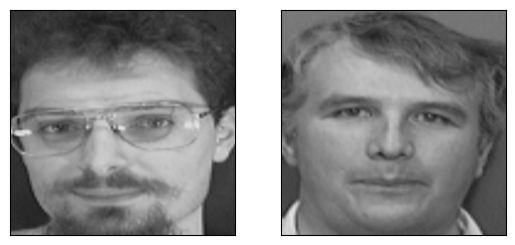

-----------------------------------------
1/1 [==============================] - 0s 29ms/step
Similaridade com distancia do cosseno:  0.0015839338302612305
Similaridade com distancia euclideana:  2.5814261
Verificado! Mesma pessoa!


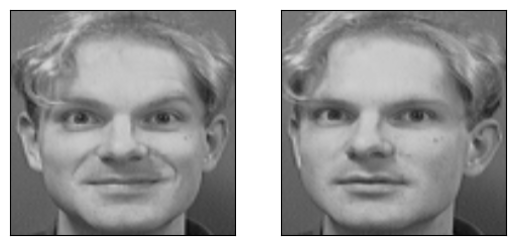

-----------------------------------------
1/1 [==============================] - 0s 28ms/step
Similaridade com distancia do cosseno:  0.0028215646743774414
Similaridade com distancia euclideana:  3.5512438
Verificado! Mesma pessoa!


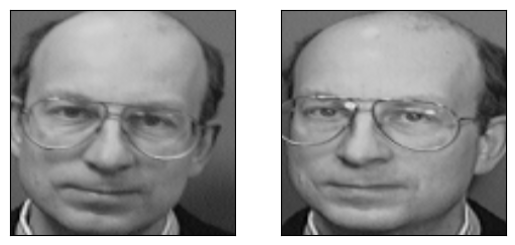

-----------------------------------------
1/1 [==============================] - 0s 30ms/step
Similaridade com distancia do cosseno:  0.012392163276672363
Similaridade com distancia euclideana:  7.228704
Não-verificado! Não são a mesma pessoa!


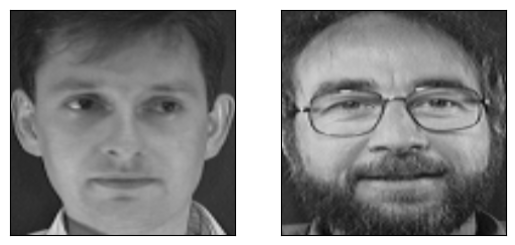

-----------------------------------------


In [ ]:
import cv2

# Ajuste as imagens para a entrada do modelo VGG

# exemplo, para o par 64 e 33 :
pares = [(64, 33), (3, 7), (40, 44), (100, 200)]
for par in pares:
  # Realiza os processos nos dois pares de imagens
  img1 = preprocess_image(par[0])
  img2 = preprocess_image(par[1])

  #Plotando as imagens e realizando a comparação
  verifyFace(img1, img2)

In [ ]:
#import cv2

# Ajuste as imagens para a entrada do modelo VGG

# exemplo, para o par 64 e 33 :

# Todo : Normaliza entre 0 e 1 , dividindo por 255
#img1 = X[64,:,:,:] # Todo
#img2 = X[33,:,:,:] # Todo

# Redimensione a imagem para (224,224) e coloca a primeira dimensão unitária
#img1 = cv2.resize( # Todo
#img2 = cv2.resize( # Todo

# lembre-se de expandir a primeira dimensão, pois nosso lote aqui é de 1 imagem
#img1 = np.expand_dims( # Todo ..
#img2 = np.expand_dims( # Todo ..

#verifyFace(img1, img2)

# 4. Transferência de aprendizado (50pt)


Estude o tutorial do [link](https://www.tensorflow.org/tutorials/images/transfer_learning) e aplique o mesmo procedimento para ajustar um modelo previamente treinado com imagens da imagenet.
Use o MobileNetV2 como modelo base.

Todo: Faça o procedimento em duas etapas:


1.   Congele todas as camadas exceto as novas que você adicinou ao modelo. Treine.
2.   Libere todas as camadas paar o treinamento e treine novamente com um Learning Rate bem pequeno (um décimo do realizado no ítem 1).

In [ ]:
# Usando o mobileNet, as imagens devem ter entrada de 160x160x3 e normalizadas entre 0 e 1.
# Use a funçao abaixo para fazer o trabalho, conjuntamente com tf.data.Dataset.from_tensor_slices

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
X_train.shape

(280, 112, 92, 3)

In [ ]:
# Tensorflow tem funções especĩficas para carregar os dados. Veja tf.data.Dataset

raw_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
raw_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
train = raw_train.map(format_example)
test = raw_test.map(format_example)

Seus dados devem ter o formato :



```
TensorShape([Dimension(280), Dimension(160), Dimension(160), Dimension(3)])

```



In [ ]:
SHUFFLE_BUFFER_SIZE = 32
BATCH_SIZE = 32

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## 4.1. Execute os passos (35pt):




1. Carregue o modelo pré-treinado do MobileNet, remova a última camada.
2. Adicione uma camada de Global Average Pooling 2D (GAP)
3. Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax
4. Use função de custo loss='sparse_categorical_crossentropy'
5. Dentre os dados de treinamento, reserve 10% para validação do modelo.
6. Treine por 10 épocas.
7. Plote os gráficos de custo do treino e validação


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 mobilenet_1.00_160 (Functi  (None, 5, 5, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_7  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
Total params: 3280114 (12.51 MB)
Trainable params: 51250 (200.20 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________
Epoch 1/10
9/9

0.9666666388511658

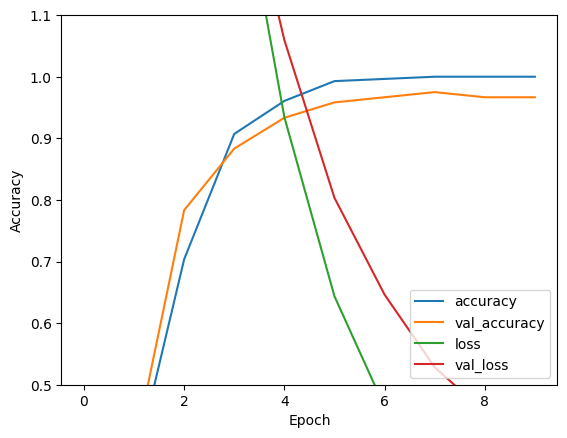

In [ ]:
#1. Carregue o modelo pré-treinado do MobileNet, remova a última camada.
from tensorflow.keras.applications import MobileNet

#MobileNet = MobileNet()
#MobileNet_face_descriptor = Model(inputs=MobileNet.layers[0].input, outputs=MobileNet.layers[-1].output)

IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = MobileNet(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')
base_model.trainable = False

#base_model.summary()


#2. Adicione uma camada de Global Average Pooling 2D (GAP)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(base_model.output)
#print(base_model.output.shape)

#3. Adicione uma camada densa para ajustar ao seu número de classes e use ativação softmax

prediction_layer = tf.keras.layers.Dense(50, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

#4. Use função de custo loss='sparse_categorical_crossentropy'

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


#5. Dentre os dados de treinamento, reserve 10% para validação do modelo.
#6. Treine por 10 épocas.

history = model.fit(train_batches,
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches)

#7. Plote os gráficos de custo do treino e validação

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_batches, verbose=2)
test_acc

## 4.2. Fazendo testes (13pt)

Analize os gráficos. Você provavelmente deve ter observado overfitting.
Todo: Aplique algumas regularizações no modelo, para tentar reduzir o super-ajuste.Tente as opções abaixo:



1.   Dropout, antes da camada densa, de 50%
2.   Regularização nos pesos da camada densa (L1 ou L2)
3.   Dropout antes da camada de GAP



Veja exemplos no [link](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 mobilenet_1.00_160 (Functi  (None, 5, 5, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_7  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
Total params: 3280114 (12.51 MB)
Trainable params: 51250 (

0.9916666746139526

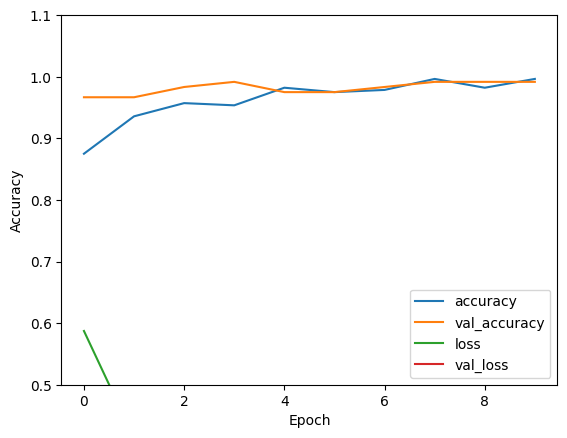

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)

#1. Dropout, antes da camada densa, de 50%
x = tf.keras.layers.Dropout(0.5)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_batches, verbose=2)
test_acc

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 mobilenet_1.00_160 (Functi  (None, 5, 5, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_7  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
Total params: 3280114 (12.51 MB)
Trainable params: 51250 (200.20 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________
Epoch 1/10
9/9

0.9916666746139526

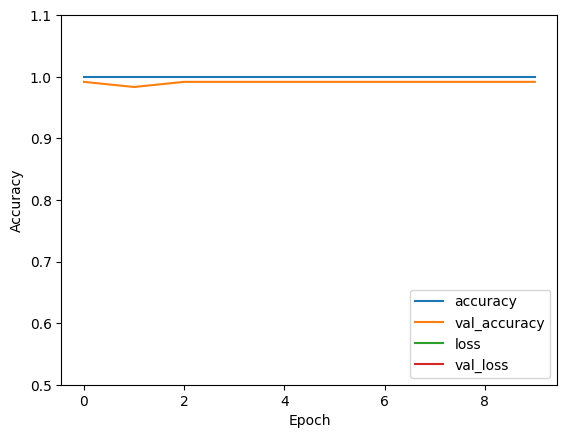

In [ ]:
#2.Regularização nos pesos da camada densa (L1 ou L2)

regularizer_layer = tf.keras.layers.Dense(50, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))
regularizer_batch = regularizer_layer(feature_batch_average)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_batches, verbose=2)
test_acc


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 mobilenet_1.00_160 (Functi  (None, 5, 5, 1024)        3228864   
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 1024)        0         
                                                                 
 global_average_pooling2d_7  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 50)                51250     
                                                                 
Total params: 3280114 (12.51 MB)
Trainable params: 51250 (

0.9916666746139526

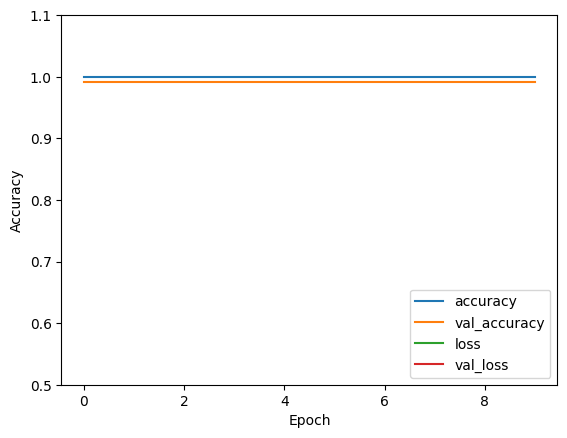

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)

#3. Dropout antes da camada de GAP
x = tf.keras.layers.Dropout(0.5)(x)

x = global_average_layer(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    validation_data=test_batches)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_batches, verbose=2)
test_acc

### Responda (2pt)

**ToDo** - com qual configuração conseguiu resolver o overfitting?

O overfitting ocorre quando um modelo é treinado muito bem para um conjunto de dados específico, mas falha em generalizar bem para novos dados que não foram usados durante o treinamento. No nosso caso não tivemos este problema, pois analisando visualmente pelos graficos conseguimos perceber que a nossa rede treinada consegue apresentar bons resultados com os dados de validação, que no caso são os novos dados.